In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity, mean_squared_error

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

---
## Загрузка изображения и гистограмма

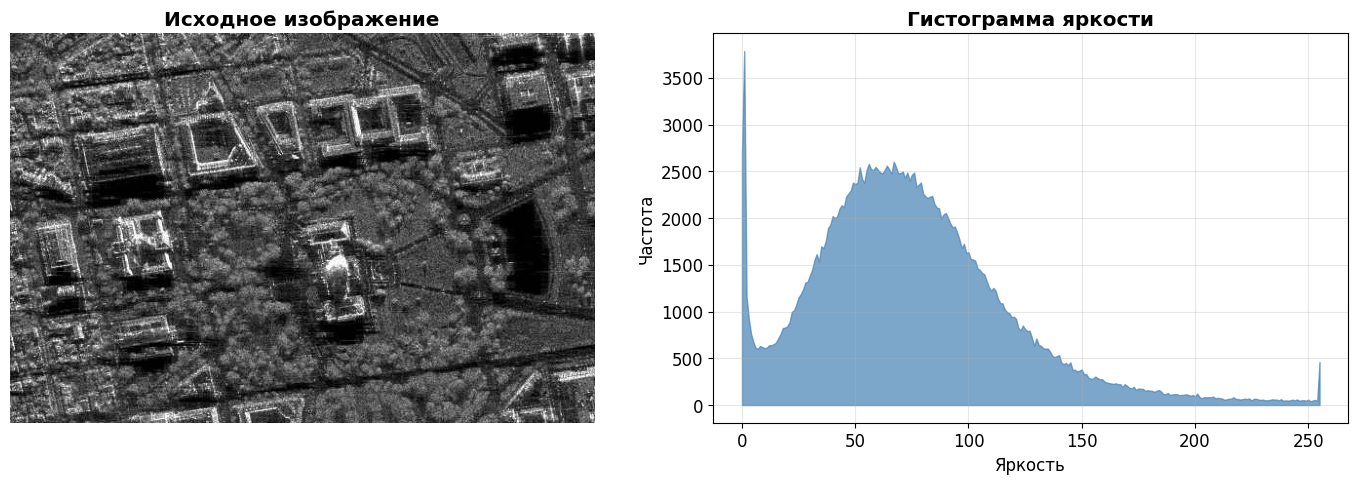

In [ ]:
image = cv2.imread('sar_1_gray.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([image_gray], [0], None, [256], (0, 256))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('Исходное изображение', fontweight='bold')
axes[0].axis('off')

axes[1].fill_between(range(256), hist.flatten(), alpha=0.7, color='steelblue')
axes[1].set_title('Гистограмма яркости', fontweight='bold')
axes[1].set_xlabel('Яркость')
axes[1].set_ylabel('Частота')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Гамма-коррекция

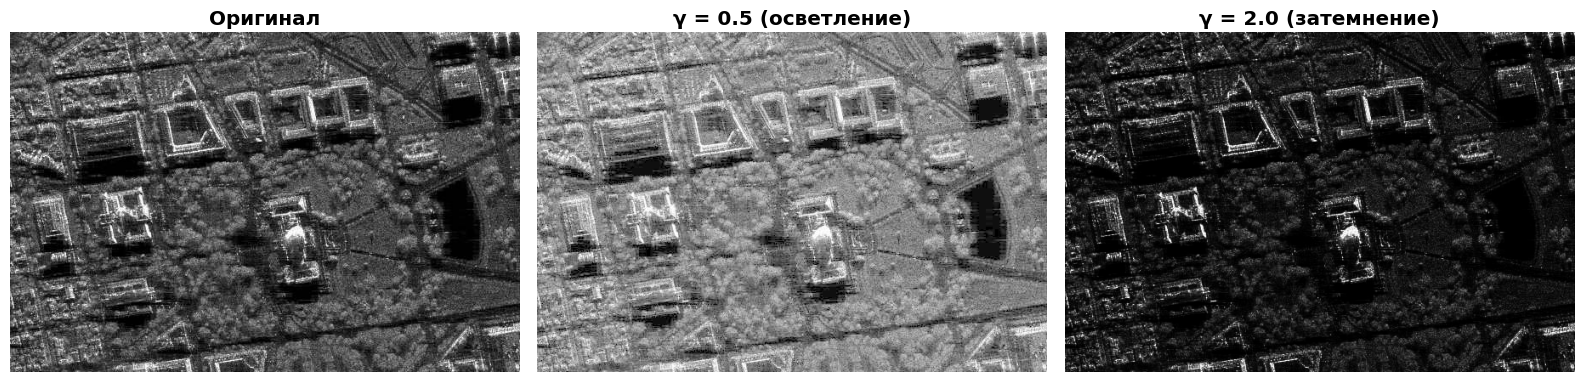

In [ ]:
def gamma_correction(source, gamma):
    """Гамма-коррекция: gamma < 1 осветляет, gamma > 1 затемняет"""
    normalized = source / 255.0
    corrected = np.power(normalized, gamma)
    return (corrected * 255).astype(np.uint8)

# Применение
gamma_low, gamma_high = 0.5, 2.0
image_gamma_low = gamma_correction(image, gamma_low)
image_gamma_high = gamma_correction(image, gamma_high)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titles = ['Оригинал', f'γ = {gamma_low} (осветление)', f'γ = {gamma_high} (затемнение)']
images = [image, image_gamma_low, image_gamma_high]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title, fontweight='bold')
    ax.axis('off')
plt.tight_layout()
plt.show()

---
## Сравнение изображений (MSE, SSIM)

СРАВНЕНИЕ ИЗОБРАЖЕНИЙ
Метрика         γ = 0.5         γ = 2.0        
--------------------------------------------------
MSE             3250.43         2383.76        
SSIM            0.7734          0.5005         


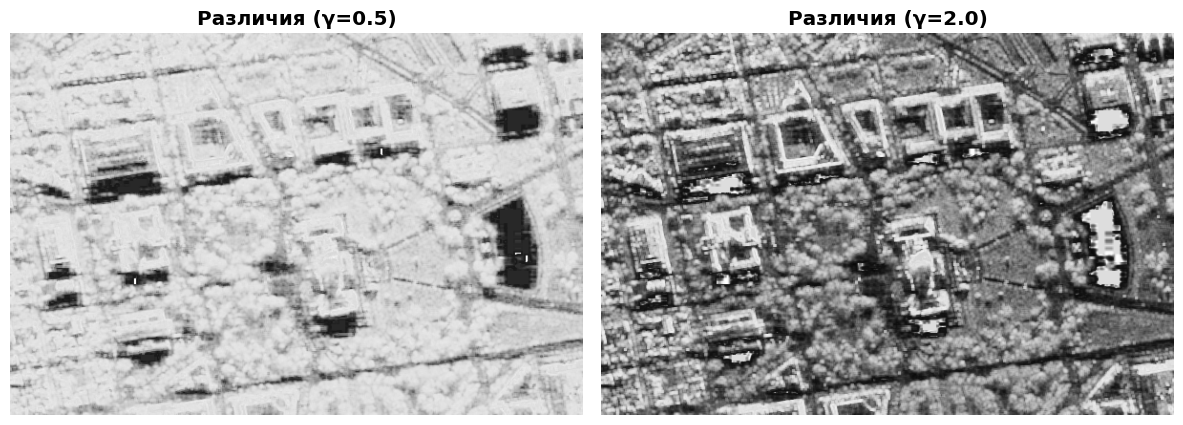

In [ ]:
(ssim_low, diff_low) = structural_similarity(image, image_gamma_low, full=True, win_size=3, channel_axis=2)
mse_low = mean_squared_error(image, image_gamma_low)

(ssim_high, diff_high) = structural_similarity(image, image_gamma_high, full=True, win_size=3, channel_axis=2)
mse_high = mean_squared_error(image, image_gamma_high)

print('=' * 50)
print('СРАВНЕНИЕ ИЗОБРАЖЕНИЙ')
print('=' * 50)
print(f"{'Метрика':<15} {'γ = 0.5':<15} {'γ = 2.0':<15}")
print('-' * 50)
print(f"{'MSE':<15} {mse_low:<15.2f} {mse_high:<15.2f}")
print(f"{'SSIM':<15} {ssim_low:<15.4f} {ssim_high:<15.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow((diff_low * 255).astype('uint8'))
axes[0].set_title(f'Различия (γ={gamma_low})', fontweight='bold')
axes[0].axis('off')
axes[1].imshow((diff_high * 255).astype('uint8'))
axes[1].set_title(f'Различия (γ={gamma_high})', fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

---
## Статистическая цветокоррекция

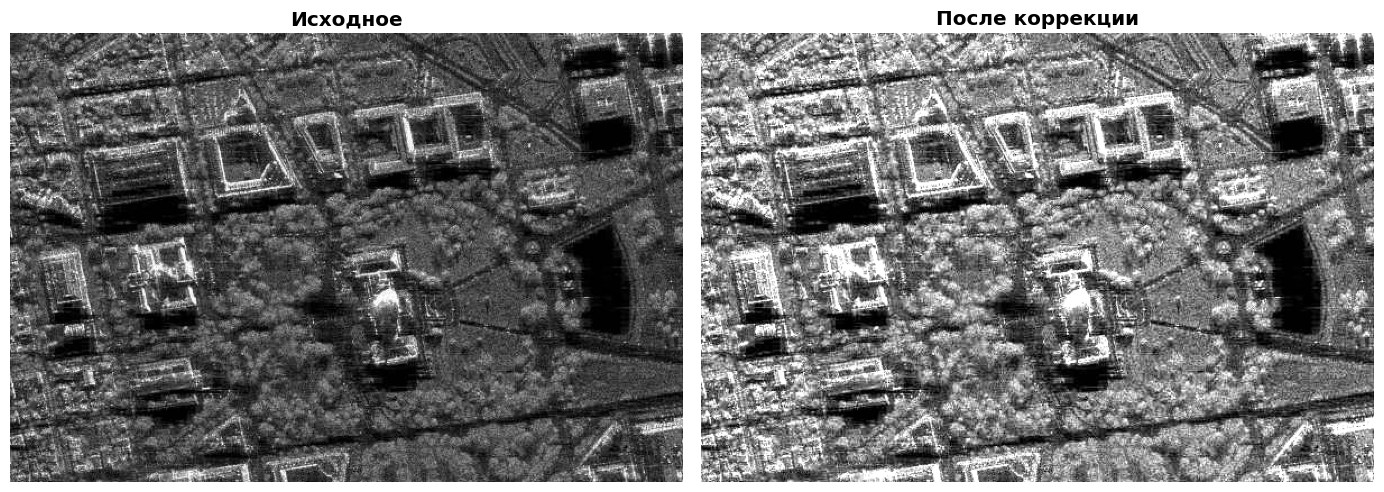

Среднее: 74.94 → 123.12
Стд.откл.: 43.66 → 65.30


In [ ]:
def statistical_color_correction(source):
    """Коррекция на основе статистики эквализированного изображения"""
    eq_gray = cv2.equalizeHist(cv2.cvtColor(source, cv2.COLOR_BGR2GRAY))
    corrected = ((source.astype(np.float32) - source.mean()) * 
                 (eq_gray.std() / source.std()) + eq_gray.mean())
    return np.clip(corrected, 0, 255).astype(np.uint8)

image_corrected = statistical_color_correction(image)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Исходное', fontweight='bold')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(image_corrected, cv2.COLOR_BGR2RGB))
axes[1].set_title('После коррекции', fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f'Среднее: {image.mean():.2f} → {image_corrected.mean():.2f}')
print(f'Стд.откл.: {image.std():.2f} → {image_corrected.std():.2f}')

---
## Пороговая фильтрация

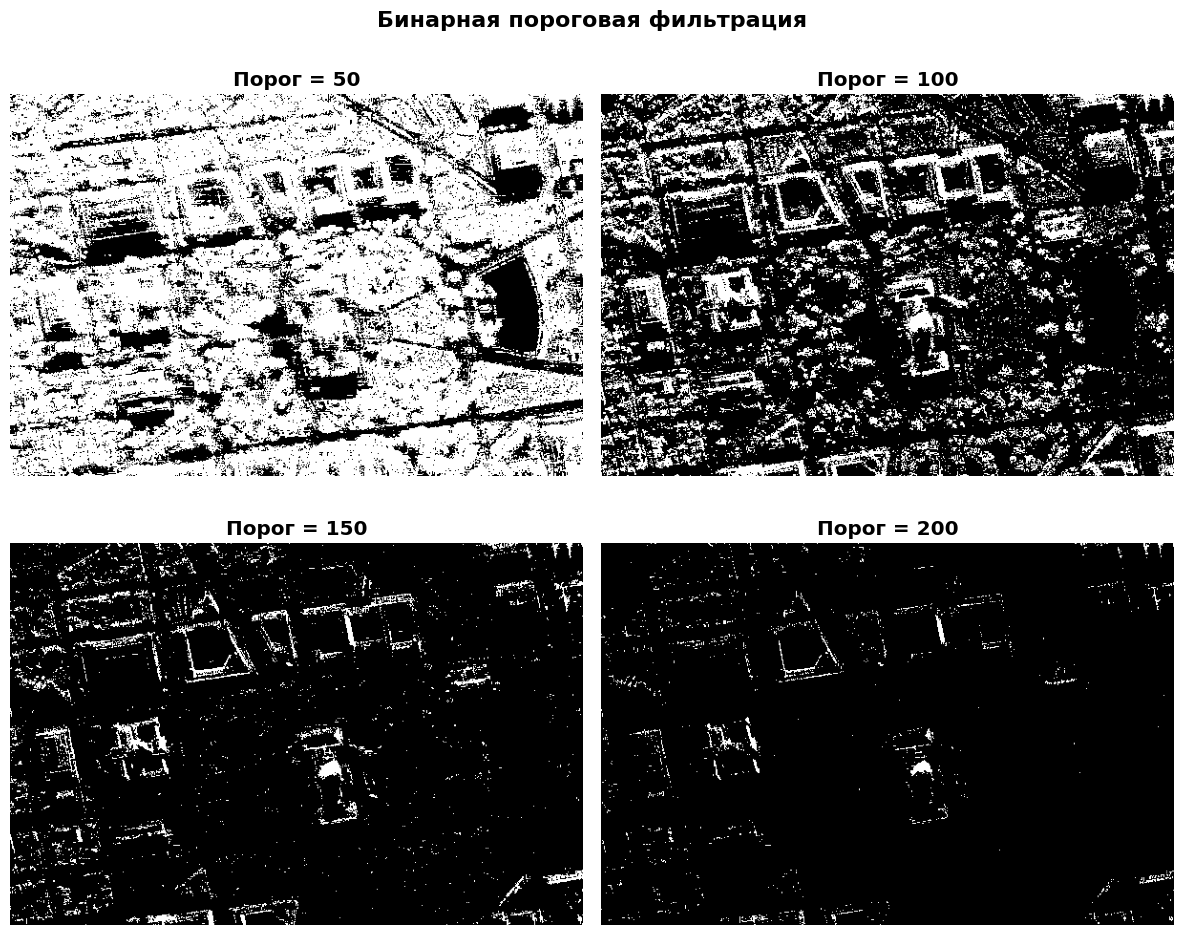

In [ ]:
thresholds = [50, 100, 150, 200]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, T in zip(axes.flatten(), thresholds):
    _, result = cv2.threshold(image_gray, T, 255, cv2.THRESH_BINARY)
    ax.imshow(result, cmap='gray')
    ax.set_title(f'Порог = {T}', fontweight='bold')
    ax.axis('off')
plt.suptitle('Бинарная пороговая фильтрация', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()